In [6]:
pip install numpy tensorflow gym matplotlib

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Episode: 1, Total Reward: 19.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━

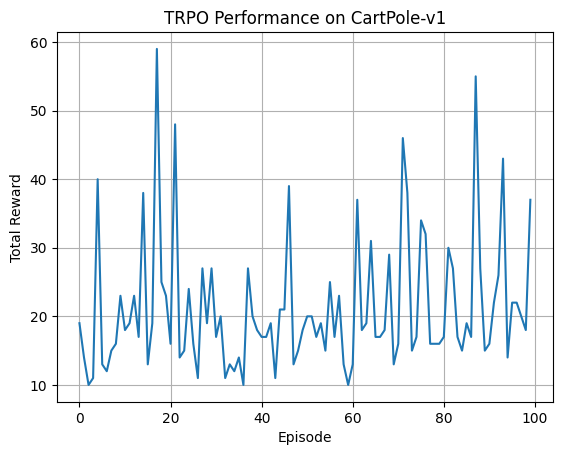

In [8]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

class TRPOAgent:
    def __init__(self, state_size, action_size, hidden_units=64, damping=0.1, kl_threshold=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_units = hidden_units
        self.damping = damping
        self.kl_threshold = kl_threshold

        # Build the model
        self.policy_model = self.build_model()
        self.value_model = self.build_value_model()

        # Initialize optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),  # Use Input layer
            tf.keras.layers.Dense(self.hidden_units, activation='tanh'),
            tf.keras.layers.Dense(self.hidden_units, activation='tanh'),
            tf.keras.layers.Dense(self.action_size, activation='softmax')  # Softmax output
        ])
        return model

    def build_value_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),  # Use Input layer
            tf.keras.layers.Dense(self.hidden_units, activation='tanh'),
            tf.keras.layers.Dense(self.hidden_units, activation='tanh'),
            tf.keras.layers.Dense(1)  # Single output for value
        ])
        return model

    def get_action(self, state):
        state = state.reshape([1, self.state_size])
        probs = self.policy_model(state).numpy()[0]

        # Add epsilon to avoid NaN values
        epsilon = 1e-10
        probs = np.clip(probs, epsilon, 1 - epsilon)  # Clip probabilities

        return np.random.choice(self.action_size, p=probs)

    def train(self, states, actions, rewards, next_states, done):
        advantages = rewards - self.value_model.predict(states).flatten()

        # Calculate the policy gradient
        with tf.GradientTape() as tape:
            actions_onehot = tf.keras.utils.to_categorical(actions, num_classes=self.action_size)
            old_probs = self.policy_model(states)
            new_probs = self.policy_model(states)
            ratio = tf.reduce_mean(new_probs * actions_onehot / (old_probs * actions_onehot + 1e-10))
            loss = -tf.reduce_mean(ratio * advantages)

        # Get the gradients
        grads = tape.gradient(loss, self.policy_model.trainable_variables)

        # Update the policy model
        self.optimizer.apply_gradients(zip(grads, self.policy_model.trainable_variables))

    def conjugate_gradient(self, states, advantages):
        # Placeholder for conjugate gradient computation
        return np.random.rand(*states.shape)

# Main loop
if __name__ == "__main__":
    env = gym.make('CartPole-v1', new_step_api=True)  # Use the new step API
    agent = TRPOAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n)

    episodes = 100
    total_rewards = []  # List to store total rewards for each episode

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)  # Unpacking for new step API
            done = terminated or truncated  # Set done based on terminated or truncated
            agent.train(np.array([state]), np.array([action]), np.array([reward]), np.array([next_state]), done)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)  # Append total reward of this episode
        print(f'Episode: {episode + 1}, Total Reward: {total_reward}')

    # Plotting the total rewards over episodes
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('TRPO Performance on CartPole-v1')
    plt.grid()
    plt.show()
